In [1]:
from DS_healpix_fragmentation import *
from DS_WCS_projections import show_pic
import numpy as np
import healpy as hp
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt
from skimage.filters import gaussian
from skimage.draw import circle
import pandas as pd
from astropy.table import Table
from tqdm.notebook import tqdm
from threading import Thread
import os

In [2]:
ra, dec, radius = 194.9356, 28.0256, 1.1

In [3]:
big_nside, big_ipix = find_biggest_pixel(ra, dec, radius)
depth = 8
small_nside = big_nside * (2 ** depth)
small_nside

2048

In [4]:
big_matr = one_pixel_fragmentation(big_nside, big_ipix, depth)
mdict = matr2dict(big_matr)

In [3]:
def pix_in_radec(pix, nside, ra, dec, rad):
    sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    theta, phi = hp.pix2ang(nside, pix, lonlat=True, nest=True)
    sc2 = SkyCoord(l=theta*u.degree, b=phi*u.degree, frame='galactic')
    return sc.separation(sc2).degree < rad

In [9]:
dirname = '/home/rt2122/Data/Planck/'
files = next(os.walk(dirname))[-1]
files

['HFI_SkyMap_217_2048_R3.01_full.fits',
 'HFI_SkyMap_545_2048_R3.01_full.fits',
 'HFI_SkyMap_857_2048_R3.01_full.fits',
 'HFI_SkyMap_100_2048_R3.01_full.fits',
 'HFI_SkyMap_353_2048_R3.01_full.fits',
 'HFI_SkyMap_143_2048_R3.01_full.fits']

In [6]:
planck_nside = None
planck_pic = np.zeros((list(big_matr.shape)+[6]))
channel = 'I_STOKES'
for i_ch, file in enumerate(files):
    with fits.open(os.path.join(dirname, file)) as hdul:
        planck_nside = hdul[1].header['NSIDE']
        last_pix = hdul[1].header['LASTPIX']
        pixels = np.arange(last_pix + 1)
        #data = hdul[1].data[channel]
        in_rad = pix_in_radec(pixels, planck_nside, ra, dec, 2)
        data = hdul[1].data[channel][in_rad]
        pixels = pixels[in_rad]
        print(np.count_nonzero(in_rad))
        
        for i in tqdm(range(pixels.shape[0])):
            #pix = pixels[i]
            #pix = one_pixel_fragmentation(planck_nside, pix, 4)
            #pix = pix.flatten()
            #pix = [mdict[p] for p in pix if p in mdict]
            #if len(pix) > 0:
                #planck_pic[pix, 0] = data[i]
            pix = pixels[i]
            if pix in mdict:
                planck_pic[mdict[pix], i_ch] = data[i]

15339



15339



15339



15339



15339



15339


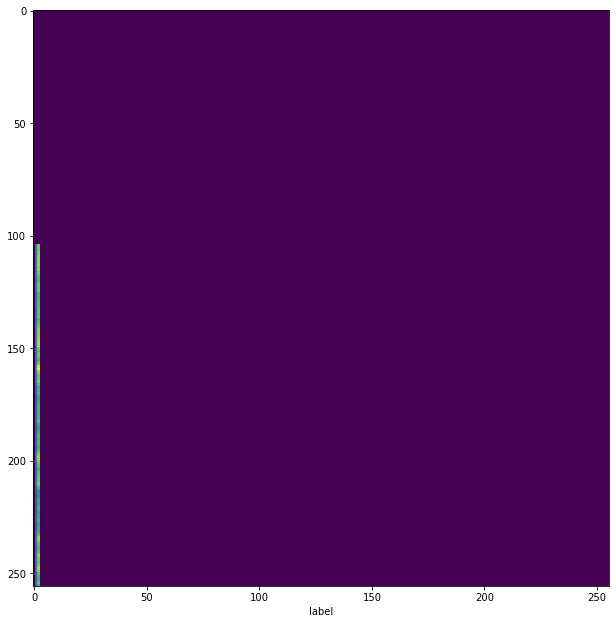

In [8]:
show_pic(planck_pic[:,:,1], vmax=planck_pic.max())

In [27]:
planck_pic.max()

0.00016150684677995741

['HFI_SkyMap_217_2048_R3.01_full.fits',
 'HFI_SkyMap_545_2048_R3.01_full.fits',
 'HFI_SkyMap_857_2048_R3.01_full.fits',
 'HFI_SkyMap_100_2048_R3.01_full.fits',
 'HFI_SkyMap_353_2048_R3.01_full.fits',
 'HFI_SkyMap_143_2048_R3.01_full.fits']

In [42]:
planck_pic = np.zeros((list(matr.shape)+[6]))
channel = 'I_STOKES'

for n_ch, fits_file in enumerate(files):
    fits_file = os.path.join(dirname, fits_file)
    with fits.open(fits_file) as hdul:
        #print(repr(hdul[1].data.columns))
        planck_nside = hdul[1].header['NSIDE']
        last_pix = hdul[1].header['LASTPIX']
        pixels = np.arange(last_pix + 1)
        pixels = pix2pix(pixels, planck_nside, small_nside)
        for i in tqdm(range(pixels.shape[0])):
            pix = pixels[i]
            if pix in mdict:
                planck_pic[mdict[pix], n_ch] = hdul[1].data[channel][i]

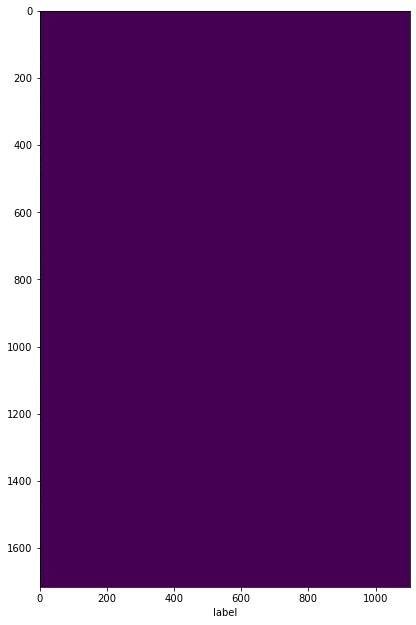

In [58]:
show_pic(planck_pic[:,:,4])

In [50]:
for i, ch in enumerate((100, 143, 217, 353, 545, 857)):
    hdu = fits.ImageHDU(planck_pic[:,:,i])
    hdu.writeto(os.path.join('/home/rt2122/Data/Planck/', 'planck_coma' + str(ch) +'.fits'))

In [52]:
for i in range(6):
    planck_pic[:,:,i] -= planck_pic[:,:,i].min()
    planck_pic[:,:,i] /= planck_pic[:,:,i].max()

In [76]:
planck_pic.max()

0.00020448409486562014

In [81]:
planck_pic[planck_pic == 100] = 0

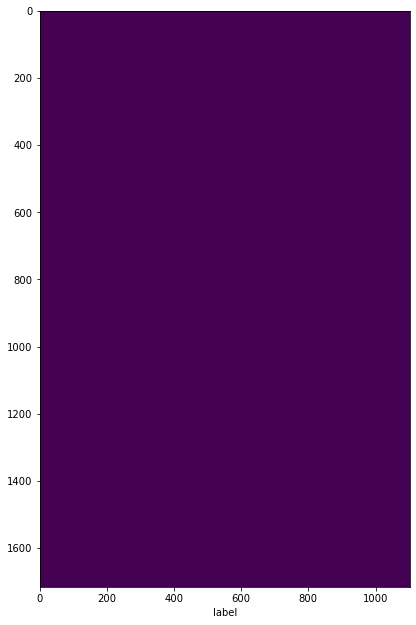

In [82]:
show_pic(planck_pic[:,:,0])

In [84]:
np.count_nonzero(planck_pic[:,:,0])

1716

In [5]:
coords = draw_proper_circle(ra, dec, small_nside, list(big_matr.shape) + [1], mdict, 1.1)
small_matr = zoom_to_circle(coords, big_matr)

In [ ]:
planck_nside = 2048
pixels = np.arange(hp.nside2npix(planck_nside))
in_rad = [pix in small_matr.flatten() for pix in pixels]

for i_ch, file in enumerate(files):
    df = None
    with fits.open(os.path.join(dirname, file)) as hdul:
        tbl = Table(hdul[1].data)
        names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
        df = tbl[names].to_pandas()
    
    print(len(in_rad), np.count_nonzero(in_rad))
    print(df.shape)
    df['pix'] = np.arange(df.shape[0])
    df = df[in_rad]
    df.index = np.arange(df.shape[0])
    df.to_csv(os.path.join('/home/rt2122/Data/Planck/dataframe1', 
                                   'planck' + str(i_ch) + '.csv'), index=False)

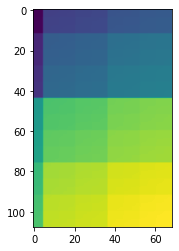

In [7]:
plt.imshow()